# Import

In [3]:
import pandas as pd
import numpy as np

POLY.csv — dataframe with 1-hour inverval over a 1 year

In [4]:
data = pd.read_csv("data/POLY.csv")
data = data.drop(["Date"], axis=1)
data.head(5)

,High,Low,Open,Close,Volume
0,535.1,533.0,534.5,533.2,109038
1,535.5,533.2,533.3,533.6,95546
2,539.9,533.2,533.5,537.6,193271
3,537.7,536.1,537.6,536.5,35374
4,538.0,535.4,536.8,537.7,51888


Choose device

In [13]:
import torch

device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

# Data preprocessing

We'll create dataset where X is last 7 candles and y is a current candle that we want to predict. Candle has 5 parameters: open price, high price, low price, close price and volume.

In [14]:
import torch
from torch.utils.data import Dataset
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

class TimeSeriesDataset(Dataset):
    def __init__(self, data: pd.DataFrame, n_steps: int, train: bool = True, test_split: float = 0.85, scale: bool = True):
        super().__init__()

        (new_df_open, new_df_low, new_df_high, new_df_close, new_df_volume) = self.shift_data(data, n_steps)

        X = np.zeros(shape=(new_df_close.shape[0], n_steps, 5), dtype=np.float32)
        X[:,:,0] = new_df_open.drop(["Open", "High", "Low", "Close", "Volume"], axis=1).values
        X[:,:,1] = new_df_high.drop(["Open", "High", "Low", "Close", "Volume"], axis=1).values
        X[:,:,2] = new_df_low.drop(["Open", "High", "Low", "Close", "Volume"], axis=1).values
        X[:,:,3] = new_df_close.drop(["Open", "High", "Low", "Close", "Volume"], axis=1).values
        X[:,:,4] = new_df_volume.drop(["Open", "High", "Low", "Close", "Volume"], axis=1).values

        y = new_df_close[["Close"]].values

        if (scale):
            scaler = MinMaxScaler(feature_range=(-1, 1))
            X[:,:,0] = scaler.fit_transform(X[:,:,0])
            X[:,:,1] = scaler.fit_transform(X[:,:,1])
            X[:,:,2] = scaler.fit_transform(X[:,:,2])
            X[:,:,3] = scaler.fit_transform(X[:,:,3])
            X[:,:,4] = scaler.fit_transform(X[:,:,4])
            y = scaler.fit_transform(y)

        test_split = int(len(X) * test_split)
        if (train):
            self.X = X[:test_split]
            self.y = y[:test_split]
        else:
            self.X = X[test_split:]
            self.y = y[test_split:]
        
        self.X = torch.tensor(self.X, dtype=torch.float32)
        self.y = torch.tensor(self.y, dtype=torch.float32)


    def __len__(self) -> int:
        return len(self.X)
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    
    def shift_data(self, data: pd.DataFrame, n_steps: int):
        new_df_close = dc(data)
        new_df_high = dc(data)
        new_df_open = dc(data)
        new_df_low = dc(data)
        new_df_volume = dc(data)

        for i in range(1, n_steps+1):
            new_df_close[f'Close(t-{i})'] = data['Close'].shift(i)

        for i in range(1, n_steps+1):
            new_df_high[f'High(t-{i})'] = data['High'].shift(i)

        for i in range(1, n_steps+1):
            new_df_open[f'Open(t-{i})'] = data['Open'].shift(i)

        for i in range(1, n_steps+1):
            new_df_volume[f'Volume(t-{i})'] = data['Volume'].shift(i)

        for i in range(1, n_steps+1):
            new_df_low[f'Low(t-{i})'] = data['Low'].shift(i)

        new_df_close.dropna(inplace=True)
        new_df_high.dropna(inplace=True)
        new_df_open.dropna(inplace=True)
        new_df_low.dropna(inplace=True)
        new_df_volume.dropna(inplace=True)

        return (new_df_open, new_df_low, new_df_high, new_df_close, new_df_volume)

We'll set train split to 95%. That means 95% of the dataset will be trainable and 5% is for testing purposes

In [15]:
train_dataset = TimeSeriesDataset(data, n_steps=7, train=True, test_split=0.95)
test_dataset = TimeSeriesDataset(data, n_steps=7, train=False, test_split=0.95)

In [16]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Neural network

Out predictor will be LSTM neural network with 5 params as input (open, high, low, close, volume), 5 hidden layers and 1 param as output (close price)

In [17]:
import torch
import torch.nn as nn

class Forecasting(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super(Forecasting, self).__init__()

        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)

        out, _ = self.lstm(x, (h0, c0))
        out = out[:,-1,:]
        out = self.fc(out)
        return out
    
model = Forecasting(5, 5, 1)
model = model.to(device)

# Train

In [18]:
def train_one_epoch(model: nn.Module, optimizer: torch.optim.Optimizer, loss_fn, dataloader: DataLoader):
    model.train()
    running_loss = 0.0

    for batch, (X_train, y_train) in enumerate(dataloader):
        X_train, y_train = X_train.to(device), y_train.to(device)

        y_pred = model(X_train)
        loss = loss_fn(y_pred, y_train)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 99:
            avg_loss = running_loss / 100.
            print(f"Batch {batch} | avg_loss: {avg_loss}")
        running_loss = 0.0
    print()

def validate_one_epoch(model: nn.Module, loss_fn, dataloader: DataLoader):
    model.eval()
    running_loss = 0.0

    for batch, (X_test, y_test) in enumerate(dataloader):
        X_test, y_test = X_test.to(device), y_test.to(device)

        with torch.no_grad():
            y_preds = model(X_test)
        
        loss = loss_fn(y_preds, y_test)
        running_loss += loss.item()
    
    avg_loss = running_loss / len(dataloader)
    print(f"val score: {avg_loss}\n")

In [19]:
lr = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = torch.nn.MSELoss()
EPOCHS = 50

for epoch in range(1, EPOCHS+1):
    print(f"Epoch {epoch}")
    print("-"*15)
    print()

    train_one_epoch(model, optimizer, loss_fn, train_loader)
    validate_one_epoch(model, loss_fn, test_loader)

Epoch 1
---------------

Batch 99 | avg_loss: 0.002103264629840851
Batch 199 | avg_loss: 9.341412223875522e-06

val score: 0.10797764934026279

Epoch 2
---------------

Batch 99 | avg_loss: 0.00014535951428115368
Batch 199 | avg_loss: 5.930556217208504e-06

val score: 0.07770076050208165

Epoch 3
---------------

Batch 99 | avg_loss: 4.5957909896969795e-05
Batch 199 | avg_loss: 5.351881845854223e-06

val score: 0.05757735039179142

Epoch 4
---------------

Batch 99 | avg_loss: 1.3730705250054598e-05
Batch 199 | avg_loss: 1.4954690122976899e-05

val score: 0.04284469683009844

Epoch 5
---------------

Batch 99 | avg_loss: 9.344362188130618e-06
Batch 199 | avg_loss: 1.1994987726211548e-05

val score: 0.03141540632798122

Epoch 6
---------------

Batch 99 | avg_loss: 8.587173069827259e-06
Batch 199 | avg_loss: 6.57692551612854e-06

val score: 0.022569943935825273

Epoch 7
---------------

Batch 99 | avg_loss: 8.755408925935626e-06
Batch 199 | avg_loss: 4.696873947978019e-06

val score: 0.

# Evaluation

/var/folders/qj/61vg9m0d3rg_8j6xhv83ptbr0000gn/T/ipykernel_75830/1099862562.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_preds = model(torch.tensor(X).to(device)).cpu().numpy()


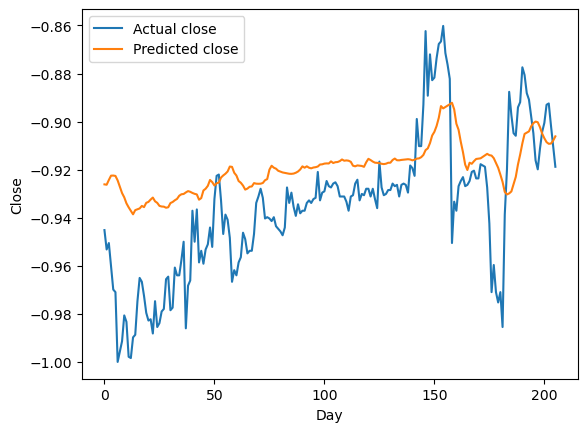

(206, 1)


In [20]:
import matplotlib.pyplot as plt

dataset = test_dataset
X = dataset.X
y = dataset.y

model.eval()
with torch.no_grad():
    y_preds = model(torch.tensor(X).to(device)).cpu().numpy()

plt.plot(y, label="Actual close")
plt.plot(y_preds, label="Predicted close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()

print(y_preds.shape)